In [1]:
%matplotlib inline

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/LodeSTAR/06.track_plankton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:
import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import datetime
import imageio

/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [3]:
def load_video(path, start=0, end=None):
    video= cv2.VideoCapture(path)
    frames=[]
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if end:
        end = min(end, total_frames)
    else:
        end = total_frames
    for i in tqdm(range(start, end), desc="loading frames"):
        video.set(1, i)
        ret, frame=video.read()
        gray_frame = frame#[:,:,0]
        frames.append(gray_frame)
    return np.array(frames)

In [4]:
path = "/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/plankton_videos/MVI_5969.MOV"
frames = load_video(path)

loading frames: 100%|██████████| 521/521 [00:33<00:00, 15.42it/s]


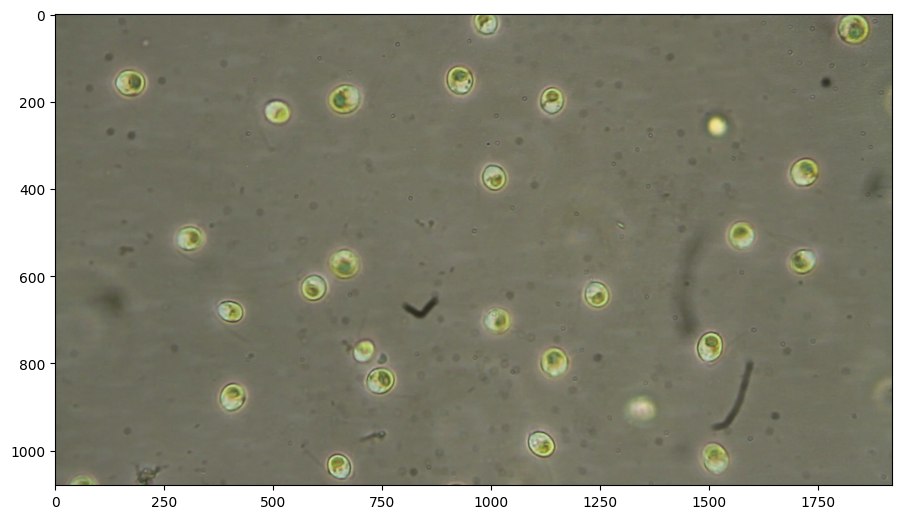

In [5]:
# %matplotlib tk
# To display image in original colors
dpi = 100
frame = frames[0]
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.show()


In [6]:
plankton_positions = [[1005,375], [1139,198], [166,157], [1575,511], [525,222], [408,690]]

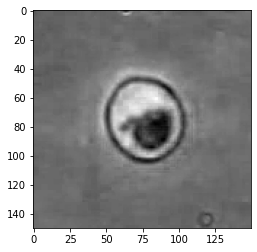

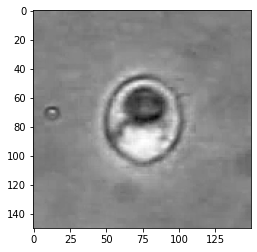

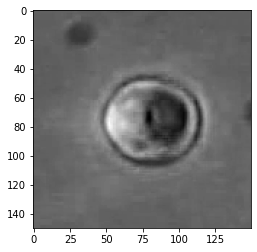

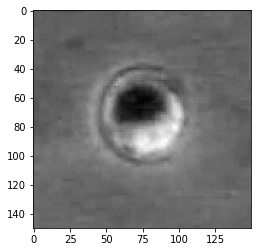

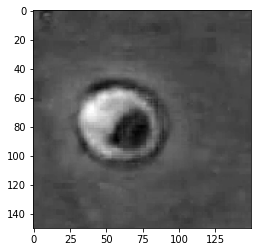

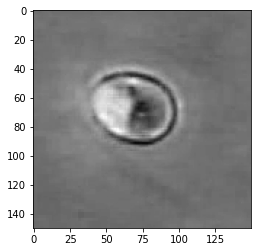

In [7]:
crop_width = 150
crops = []
for pos in plankton_positions:
    crop = frame[int(pos[1] - crop_width/2) :int(pos[1] + crop_width/2), int(pos[0] - crop_width/2) : int(pos[0] + crop_width/2)][:,:,0]
    crops.append(crop)
    plt.imshow(crop, cmap="gray")
    plt.show()
crops = np.expand_dims(crops, axis=-1)

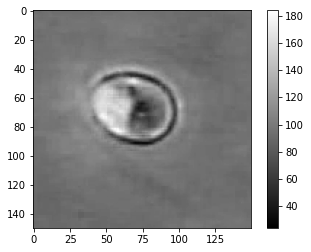

In [8]:
import random
random.seed(20)
crop = random.choice(crops)
plt.imshow(crop, cmap="gray")
plt.colorbar()

In [9]:
random_crop = dt.Value(lambda: random.choice(crops))

In [10]:
downsample = 2

In [14]:
TRAIN = False

if TRAIN:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    train_set =   (
        dt.Value(random_crop)
        >> dt.AveragePooling(ksize=(downsample, downsample, 1))
        # >> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(0.95, 1.05, 2))
        # >> dt.Add(lambda: np.random.randn() * 0.2)
        # >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  
        # >> dt.Multiply(lambda: np.random.uniform(0.3, 1.6))
    )

    model.fit(
        train_set,
        epochs=30,
        batch_size=8,
        verbose=1
    )

    model.model.model.save_weights("planktons-lodestar-{}.h5".format(date))

else:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    model.model.model.load_weights("planktons-lodestar-2022-07-15.h5")

In [27]:
crop2 = np.expand_dims(crop, axis=0)

In [28]:
p, w = model.predict(crop2)

1/1 [==============================] - 0s 280ms/step


2022-07-27 15:05:59.775701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


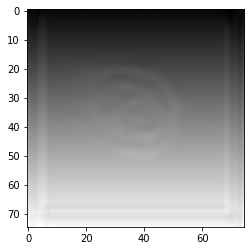

In [31]:
plt.imshow(p[0,:,:,0], cmap="gray")

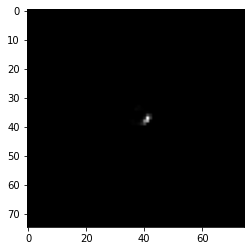

In [34]:
plt.imshow(w[0,:,:,0], cmap="gray")

In [89]:
#May need to tune these to get optimal performance!
alpha = 1
cutoff = 0.1

starting_frame = 0
ending_frame = len(frames)

frames2 = np.expand_dims(frames[:,:,:,0], axis=-1)
detections = model.predict_and_detect(frames2[starting_frame:ending_frame, ::downsample, ::downsample, :1], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="constant")


17/17 [==============================] - 85s 5s/step


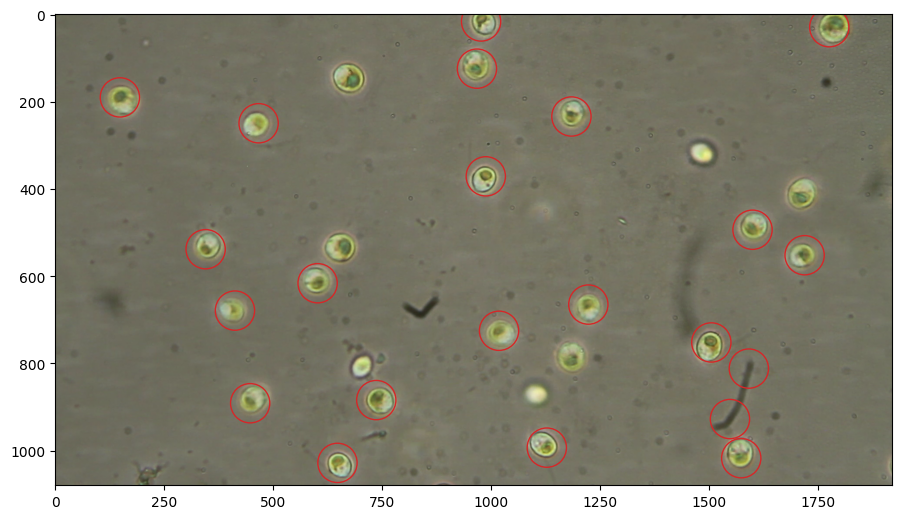

In [91]:
frame_no = 9
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi)
plt.imshow(cv2.cvtColor(frames[frame_no], cv2.COLOR_BGR2RGB))
plt.scatter(detections[frame_no][:,1] * downsample , detections[frame_no][:,0] * downsample, s = 800, facecolors="none", edgecolors="tab:red")

In [92]:
_dpi = 200
images = []
path = "/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/plankton_videos/MVI_5969_detections.mp4"

for i in range(len(frames)):
    fig, ax = plt.subplots(
        figsize=(frame.shape[1]/ _dpi, frame.shape[0] / _dpi), dpi=_dpi, frameon=False
    )
    ax.set_axis_off()
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), origin="upper")
    plt.scatter(
        detections[i][:, 1] * downsample,
        detections[i][:, 0] * downsample,
        s=800,
        facecolors="none",
        edgecolors="tab:red",
    )
    fig.canvas.draw()
    arr = np.array(fig.canvas.renderer.buffer_rgba())
    images.append(arr)

    fig.clear()
    plt.close(fig)
    plt.show()

imageio.mimsave(path, images, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
